In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import os

from wmfdata import charting, hive,spark

In [2]:
# UPDATE FOR NEW MONTH!
# Start included, end excluded.
# Have to set the end back a couple of months to ensure we only get uncensored data.
# To-do: We take the metric month and look backwards. But this results in censored data
# for months under 30 days (February).

#START = '2019-05'
#END = '2019-06'
#MWH_SNAPSHOT = '2019-07'

last_month = datetime.date.today().replace(day=1) - datetime.timedelta(days=1)
last_two_month = datetime.date.today().replace(day=1) - datetime.timedelta(days= 35)
last_three_month = datetime.date.today().replace(day=1) - datetime.timedelta(days= 70)


START = last_three_month.strftime("%Y-%m")
END = last_two_month.strftime("%Y-%m")
MWH_SNAPSHOT = last_month.strftime("%Y-%m") # The latest available mediawiki_history snapshot

In [3]:
%matplotlib inline
charting.set_mpl_style()

In [4]:
START

'2021-04'

# Update table

In [5]:
# Create the table if necessary
hive.run(
"""
CREATE EXTERNAL TABLE IF NOT EXISTS wmf_product.new_editors ( 
    `user_name` string, 
    `wiki` string, 
    `user_id` bigint, 
    `1st_month_edits` bigint, 
    `2nd_month_edits` bigint  
) 
PARTITIONED BY (`cohort` string) 
STORED AS PARQUET
"""
)

In [6]:
hive.run(
    """
    INSERT OVERWRITE TABLE wmf_product.new_editors
    PARTITION(cohort= "{start}")
    
    SELECT 1st_month.user_name AS user_name,
       1st_month.wiki AS wiki,
       1st_month.user_id AS user_id,
       1st_month.edits AS 1st_month_edits,
                           coalesce(2nd_month.edits, 0) AS 2nd_month_edits
    FROM
      ( SELECT event_user_text AS user_name,
               wiki_db AS wiki,
               event_user_id AS user_id,
               substr(event_user_creation_timestamp, 0, 7) AS cohort,
               count(*) AS edits
       FROM wmf.mediawiki_history
       WHERE SNAPSHOT = "{snapshot}"
         AND event_entity = "revision"
         AND event_type = "create"
         AND NOT event_user_is_created_by_system
         AND event_user_creation_timestamp BETWEEN "{start}" and "{end}"
         AND unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") < (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (30*24*60*60))
       GROUP BY event_user_text,
                event_user_id,
                event_user_creation_timestamp,
                wiki_db ) 1st_month
    LEFT JOIN
      ( SELECT event_user_text AS user_name,
               wiki_db AS wiki,
               event_user_id AS user_id,
               substr(event_user_creation_timestamp, 0, 7) AS cohort,
               count(*) AS edits
       FROM wmf.mediawiki_history
       WHERE SNAPSHOT = "{snapshot}"
         AND event_entity = "revision"
         AND event_type = "create"
         AND NOT event_user_is_created_by_system
         AND event_user_creation_timestamp BETWEEN "{start}" and "{end}"
         AND unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") >= (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (30*24*60*60))
         AND unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") < (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (60*24*60*60))
       GROUP BY event_user_text,
                event_user_id,
                event_user_creation_timestamp,
                wiki_db ) 2nd_month ON (1st_month.user_name = 2nd_month.user_name
                                        AND 1st_month.wiki = 2nd_month.wiki
                                        AND 1st_month.cohort = 2nd_month.cohort)
    """.format(
        snapshot = MWH_SNAPSHOT,
        start = START,
        end = END
    ))

,user_name,wiki,user_id,1st_month_edits,2nd_month_edits


In [7]:
#update database access
os.system("hdfs dfs -chmod -R o+r /user/hive/warehouse/wmf_product.db/new_editors")

0

# Validate

In [8]:
# Check the monthly number of rows (i.e. new editors) from four wikis to check for duplicated data.
new_editors = hive.run(
"""
set hive.mapred.mode=nonstrict;
select wiki, cohort, count(*) as new_editors
from wmf_product.new_editors
where wiki in ("arwiki", "enwiki", "jawiki", "zhwiki")
group by wiki, cohort
order by wiki, cohort asc
limit 10000
"""
)

new_editors = (
    new_editors
    .assign(cohort = lambda df: pd.to_datetime(df["cohort"]))
    .set_index("cohort")
    .pivot(columns="wiki")
    .xs("new_editors", axis=1)
)
    
new_editors.tail()

wiki,arwiki,enwiki,jawiki,zhwiki
cohort,,,,
2021-04-01,2932,42791,3493,1829


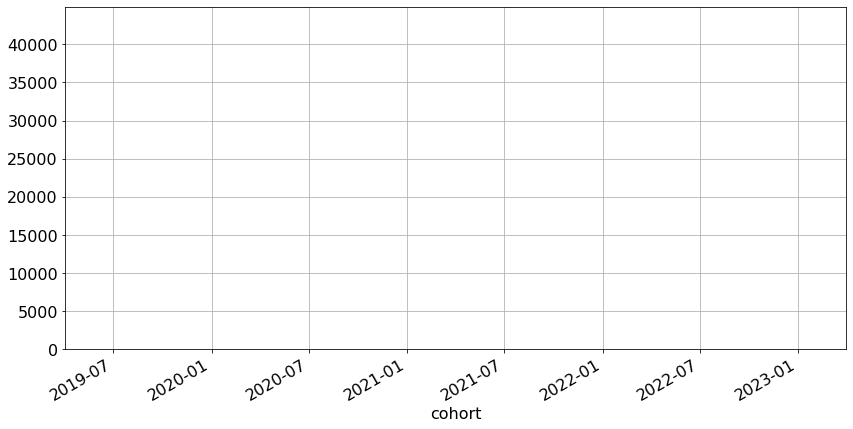

In [9]:
new_editors.loc["2015-10":, "enwiki"].plot()
plt.ylim(0);

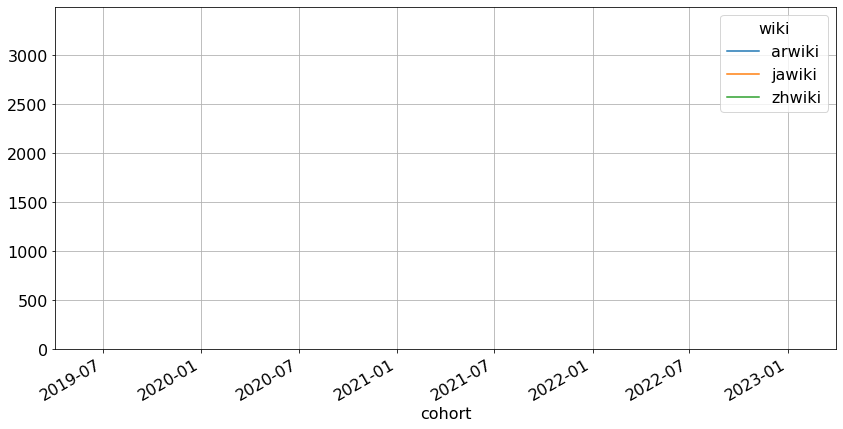

In [10]:
new_editors.loc["2015-10":, ["arwiki", "jawiki", "zhwiki"]].plot()
plt.ylim(0);